In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import files
from google.colab import drive
from PIL import Image, ImageOps
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Conv2DTranspose, UpSampling2D, TimeDistributed, Cropping3D, ConvLSTM2D, MaxPool2D, Reshape, Conv2DTranspose, Add
from tensorflow.keras import backend as kb
from tensorflow.keras import optimizers

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import io
import pandas as pd

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# dataset
input_x = 32
input_y = 32

local_download_path = os.path.expanduser('/content/drive/My Drive/Images')
img = []
for filename in os.listdir(local_download_path): 
  for images in os.listdir(os.path.join(local_download_path,filename)):
    temp = Image.open(os.path.join(os.path.join(local_download_path,filename),images))
    temp = temp.convert('L')
    img.append([images,temp.resize((input_x,input_y))])

img.sort() 


In [0]:
roti = []
# flip = []
# mir = []
norm = []

for i in range(len(img)):
#   flip.append(ImageOps.flip(img[i][1]))
#   mir.append(ImageOps.mirror(img[i][1]))
   norm.append(img[i][1])

for j in range(2,360):
  rot=[]
  for i in range(len(img)):
    rot.append(img[i][1].rotate(j))
  roti.append(rot)

In [5]:
len(roti[1])


955

In [0]:
def prepData(img):

  dataset = []

  for i in range(len(img)):
     dataset.append(np.array(img[i]))
# Take the image data from the list and stack to create a higher dimensional tensor not a 1D array of arrays
  dataset = np.stack(np.array(dataset))

# Channels last

  dataset = np.expand_dims(dataset, 3)

# preprocessing
  dataset = dataset.astype('float32')
  dataset /= 255

  return dataset


In [0]:
# flipdataset = prepData(flip)
# mirdataset = prepData(mir)
normdataset = prepData(norm)
rotdataset = []
for i in range(len(roti)):
  rotdataset.append(prepData(roti[i]))
rotdataset = np.array(rotdataset)

In [8]:
rotdataset.shape
# plt.imshow(rotdataset[300,40,:,:,0],'gray')

(358, 955, 32, 32, 1)

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
# Training and Validation sets (test)

TRAIN_SPLIT = 650 # to change
past_history = 10 # to change
future_target = 1 # to change
STEP = 1          # to change





In [0]:
x_train, y_train = multivariate_data(normdataset, normdataset, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,single_step=True)
x_val, y_val = multivariate_data(normdataset, normdataset,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,single_step=True)

In [0]:
# x_train_flip, y_train_flip = multivariate_data(flipdataset, flipdataset, 0,
#                                                    TRAIN_SPLIT, past_history,
#                                                    future_target, STEP,single_step=True)
# x_val_flip, y_val_flip = multivariate_data(flipdataset, flipdataset,
#                                                TRAIN_SPLIT, None, past_history,
#                                                future_target, STEP,single_step=True)

In [0]:
# x_train_mir, y_train_mir = multivariate_data(mirdataset, mirdataset, 0,
#                                                    TRAIN_SPLIT, past_history,
#                                                    future_target, STEP,single_step=True)
# x_val_mir, y_val_mir = multivariate_data(mirdataset, mirdataset,
#                                                TRAIN_SPLIT, None, past_history,
#                                                future_target, STEP,single_step=True)

In [0]:
# x_train=np.concatenate((x_train,x_train_flip,x_train_mir))
# x_val=np.concatenate((x_val,x_val_flip,x_val_mir))
# y_train=np.concatenate((y_train,y_train_flip,y_train_mir))
# y_val=np.concatenate((y_val,y_val_flip,y_val_mir))

In [15]:
len(roti)

358

In [0]:
for i in range(1,100):
  x_train_rot, y_train_rot = multivariate_data(rotdataset[i], rotdataset[i], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,single_step=True)
  x_val_rot, y_val_rot = multivariate_data(rotdataset[i], rotdataset[i],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,single_step=True)
  x_train=np.concatenate((x_train,x_train_rot))
  y_train=np.concatenate((y_train,y_train_rot))
  x_val=np.concatenate((x_val,x_val_rot))
  y_val=np.concatenate((y_val,y_val_rot))

In [17]:
x_train.shape

(64000, 10, 32, 32, 1)

In [0]:
BATCH_SIZE =  1 # to channge
BUFFER_SIZE = 10000 # to change

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [0]:
def my_loss(y_actual,y_predicted):
  loss_value =  kb.exp(1-kb.minimum(kb.abs(y_actual),kb.abs(y_predicted)))* kb.square(y_actual-y_predicted)
  return loss_value

In [0]:
optimizer = optimizers.Adam(0.0001,0.9)

In [21]:
input_shape = (10,32,32,1) 

inputs= Input(input_shape)

conv1 = TimeDistributed(Conv2D( 64, 3, strides=1, padding = 'same'))(inputs)
clstm1 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(conv1)
crp1_1 = Cropping3D(((9,0),(0,0),(0,0)))(clstm1)
crp1_1 = Reshape((32,32,64))(crp1_1)
crp1_2 = Cropping3D(((1,0),(0,0),(0,0)))(clstm1)
dec1 = Conv2DTranspose( 64, 3, strides=1, padding = 'same')(crp1_1)
dec1 = Conv2D( 1, 3, strides=1, padding = 'same')(dec1)
pool1 = TimeDistributed(MaxPool2D(pool_size=(2,2)))(crp1_2)

conv2 = TimeDistributed(Conv2D( 64, 3, strides=1, padding = 'same'))(pool1)
clstm2 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(conv2)
crp2_1 = Cropping3D(((8,0),(0,0),(0,0)))(clstm2)
crp2_1 = Reshape((16,16,64))(crp2_1)
crp2_2 = Cropping3D(((1,0),(0,0),(0,0)))(clstm2)
dec2 = Conv2DTranspose( 64, 3, strides=1, padding = 'same')(crp2_1)
dec2 = UpSampling2D(size=(2,2))(dec2)
dec2 = Conv2D( 1, 3, strides=1, padding = 'same')(dec2)
pool2 = TimeDistributed(MaxPool2D(pool_size=(2,2)))(crp2_2)

conv3 = TimeDistributed(Conv2D( 64, 3, strides=1, padding = 'same'))(pool2)
clstm3 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False)(conv3)
crp3_1 = Reshape((8,8,64))(clstm3)
dec3 = Conv2DTranspose( 64, 3, strides=1, padding = 'same')(crp3_1)
dec3 = UpSampling2D(size=(2,2))(dec3)
dec3 = Conv2DTranspose( 64, 3, strides=1, padding = 'same')(dec3)
dec3 = UpSampling2D(size=(2,2))(dec3)
dec3 = Conv2D( 1, 3, strides=1, padding = 'same')(dec3)

output = Add()([dec1, dec2, dec3])

FLSTM = Model(inputs = inputs, outputs = output)
FLSTM.compile(loss=my_loss, optimizer=optimizer)
FLSTM.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 32, 32,  0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 10, 32, 32, 6 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 10, 32, 32, 6 295168      time_distributed[0][0]           
__________________________________________________________________________________________________
cropping3d_1 (Cropping3D)       (None, 9, 32, 32, 64 0           conv_lst_m2d[0][0]               
______________________________________________________________________________________________

In [22]:
for x, y in val_data_multi.take(1):
  out2 = FLSTM.predict(x)
  print (out2.shape)
  print(y.shape)

(1, 32, 32, 1)
(1, 32, 32, 1)


In [0]:
FLSTM.load_weights('/content/drive/My Drive/models/FLSTM_650_weights_myloss_opt.h5')

In [24]:
EVALUATION_INTERVAL = 200
EPOCHS = 200


multi_step_history = FLSTM.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=200)

FLSTM.save_weights('/content/drive/My Drive/models/FLSTM_650_weights_myloss_opt.h5')
FLSTM.save('/content/drive/My Drive/models/FLSTM_650_model_myloss_opt.h5')

str_loss=""
with open('/content/drive/My Drive/FLSTM_650_loss_myloss_opt.txt', 'a') as f:
  f.write(str_loss.join([" "+str(elem) for elem in multi_step_history.history['loss'] ]))
str_loss=""
with open('/content/drive/My Drive/FLSTM_650_val_loss_myloss_opt.txt', 'a') as f:
  f.write(str_loss.join([" "+str(elem) for elem in multi_step_history.history['val_loss'] ]))


Epoch 1/200
200/200 [==============================] - 30s 151ms/step - loss: 5.0656e-04 - val_loss: 1.5484e-04
Epoch 2/200
200/200 [==============================] - 29s 147ms/step - loss: 3.9688e-04 - val_loss: 1.4978e-04
Epoch 3/200
200/200 [==============================] - 29s 147ms/step - loss: 3.8469e-04 - val_loss: 1.5075e-04
Epoch 4/200
200/200 [==============================] - 29s 146ms/step - loss: 3.5065e-04 - val_loss: 1.4061e-04
Epoch 5/200
200/200 [==============================] - 29s 147ms/step - loss: 2.6693e-04 - val_loss: 1.1731e-04
Epoch 6/200
200/200 [==============================] - 29s 146ms/step - loss: 4.5734e-04 - val_loss: 1.2914e-04
Epoch 7/200
200/200 [==============================] - 29s 146ms/step - loss: 4.4391e-04 - val_loss: 2.9884e-04
Epoch 8/200
200/200 [==============================] - 30s 148ms/step - loss: 4.6084e-04 - val_loss: 1.3836e-04
Epoch 9/200
200/200 [==============================] - 29s 146ms/step - loss: 3.3737e-04 - val_loss: 1.3

In [0]:
str_loss.join([" "+str(elem) for elem in multi_step_history.history['loss'] ])

' 0.0014091155026108027 0.0008698402671143413 0.000804038776550442 0.000812712823972106 0.0008043759735301137 0.0007894290029071271 0.0008332606521435082 0.0008310082484968007 0.0007742400048300624 8.024234771728516 0.07377847284078598 0.023844903334975243 0.011777492240071297 0.019780199974775314 0.00754423625767231 0.007353700697422028 0.005104769021272659 0.004413539543747902 0.003334317822009325 0.0025608406867831945 0.0029374542646110058 0.0015132582047954202 0.0017553073121234775 0.4750978350639343 0.0020832696463912725 0.0029568278696388006 0.0025997732300311327 0.00390827190130949 0.0021841744892299175 0.002133412752300501 0.0014109732583165169 0.0015022509032860398 0.0010678154649212956 0.0011454345658421516 0.0008068893221206963 0.0008861940004862845 0.0038971498142927885 0.0007492914446629584 0.0008654547273181379 0.0009335204376839101'

#150 one step

#200 epoch - five step



In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

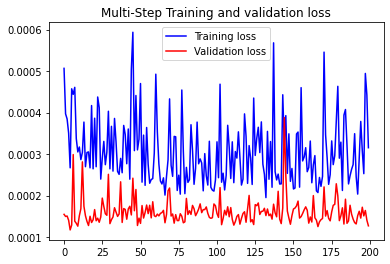

In [26]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

(1, 32, 32, 1)
(1, 32, 32, 1)
(1, 32, 32, 1)
(1, 32, 32, 1)
(1, 32, 32, 1)


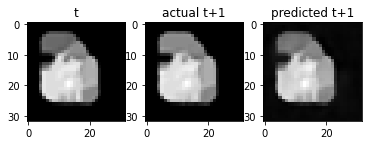

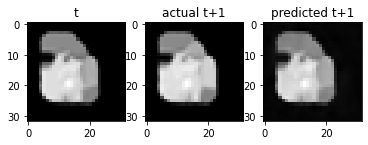

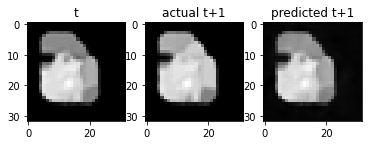

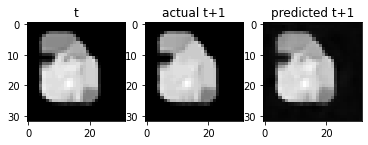

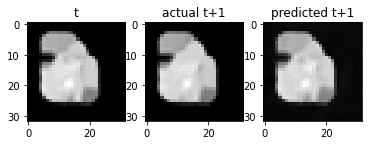

In [27]:
for x, y in val_data_multi.take(5):
  out = FLSTM.predict(x)
  print(y.shape)
  plt.figure()
  plt.subplot(1,3,1)
  plt.title('t')
  plt.imshow(x[0,9,:,:,0], 'gray')
  plt.subplot(1,3,2)
  plt.title('actual t+1')
  plt.imshow(y[0,:,:,0], 'gray')
  plt.subplot(1,3,3)
  plt.title('predicted t+1')
  plt.imshow(out[0,:,:,0], 'gray')

In [0]:
def draw_seq(train,label,start):
  seq = train[start]
  real = label[start:start+5]
  pred1 = []
  pred2 = []


  for i in range(5):
    inputs = train[start+i]
    inputs = np.expand_dims(inputs, 0)
    pred1.append(FLSTM.predict(inputs))
  pred1 = np.stack(np.array(pred1))


  inputs = seq
  inputs = np.expand_dims(inputs, 0)
  for i in range(5):
    out = FLSTM.predict(inputs)
    pred2.append(out)
    out = np.expand_dims(out, 0)
    inputs = np.concatenate((inputs[:,1:10],out), axis = 1)
  pred2 = np.stack(np.array(pred2))

  # Plot
  plt.figure()
  plt.title('Past sequence')
  for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(seq[i,:,:,0], 'gray')

  plt.figure()  
  plt.title('Actual Future')
  for i in range(5): 
    plt.subplot(1,5,i+1)
    plt.imshow(real[i,:,:,0], 'gray')

  plt.figure()  
  plt.title('Predicted 1 each sample')
  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(pred1[i,0,:,:,0], 'gray')

  plt.figure()
  plt.title('Predicted 5 on first sample')
  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(pred2[i,0,:,:,0], 'gray')
      

In [0]:
x_val[12].shape

(10, 32, 32, 1)

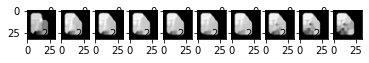

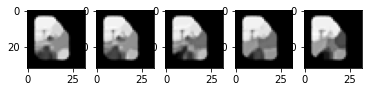

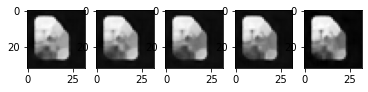

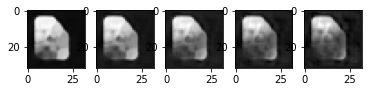

In [29]:
draw_seq(x_train,y_train,130)